Python 3.10.12  
Keras 2.2.4  -> 2.9  
TF 2.9.3  
vggface 1.0  
keras_vggface 0.6  


Experimento baseado no paper:  
# Benchmarking deep network architectures for ethnicity recognition using a new large face dataset  
A. Greco, G. Percannella, M. Vento, and V. Vigilante - Machine Vision and Applications, pp.-, 2020. Online available: https://rdcu.be/b7cX6 

In [1]:
import tensorflow as tf
print("TensorFlow version: ", tf.__version__)
gpu = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(gpu))
tf.config.experimental.set_memory_growth(gpu[0], True)
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import os
import numpy as np
from keras import layers
from keras import models
from keras import utils
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import mtcnn
print(mtcnn.__version__)
import cv2
import sys
from IPython.display import clear_output
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import shutil
from IPython.display import display
from IPython.display import Image as Img

TensorFlow version:  2.9.3
GPUs Available:  1
0.1.0


# 10.000 Imagens
Africanos:          1250 Mulheres e 1250 Homens  
Caucasianos:        1250 Mulheres e 1250 Homens  
Asiaticos Indianos: 1250 Mulheres e 1250 Homens  
Leste Asiaticos:    1250 Mulheres e 1250 Homens

In [2]:
Train = ET.parse("F:/VGG-Face2/VMER_dataset/finalTrain.xml")
Test = ET.parse("F:/VGG-Face2/VMER_dataset/finalTest.xml")
trainRoot = Train.getroot()
testRoot = Test.getroot()
trainIDX = {}
for subjct in trainRoot.iter('subject'):
    id_element = subjct.find('id')
    ethEl = subjct.find('ethnicity')
    if id_element is not None and ethEl is not None:
        subject_id = id_element.text
        ethnicity = ethEl.text
        trainIDX[subject_id] = ethnicity
print(len(trainIDX), trainIDX)
#Onde trainIDX[i][0] eh o numero do individuo e trainIDX[i][1] eh sua etnia
testIDX = {}
for subjct in testRoot.iter('subject'):
    id_element = subjct.find('id')
    ethEl = subjct.find('ethnicity')
    if id_element is not None and ethEl is not None:
        subject_id = id_element.text
        ethnicity = ethEl.text
        testIDX[subject_id] = ethnicity
print(len(testIDX) ,testIDX)
#Onde testIDX[i][0] eh o numero do individuo e testIDX[i][1] eh sua etnia


8630 {'n000002': '3', 'n000003': '3', 'n000004': '3', 'n000005': '3', 'n000006': '4', 'n000007': '4', 'n000008': '3', 'n000010': '4', 'n000011': '4', 'n000012': '3', 'n000013': '3', 'n000014': '1', 'n000015': '1', 'n000016': '3', 'n000017': '3', 'n000018': '3', 'n000019': '3', 'n000020': '3', 'n000021': '3', 'n000022': '3', 'n000023': '3', 'n000024': '3', 'n000025': '3', 'n000026': '3', 'n000027': '4', 'n000028': '4', 'n000030': '3', 'n000031': '3', 'n000032': '4', 'n000033': '4', 'n000034': '1', 'n000035': '3', 'n000036': '2', 'n000037': '3', 'n000038': '3', 'n000039': '2', 'n000041': '3', 'n000042': '3', 'n000043': '4', 'n000044': '3', 'n000045': '3', 'n000046': '3', 'n000047': '3', 'n000048': '3', 'n000049': '3', 'n000050': '3', 'n000051': '3', 'n000052': '3', 'n000053': '3', 'n000054': '3', 'n000055': '3', 'n000056': '2', 'n000057': '3', 'n000058': '3', 'n000059': '3', 'n000060': '3', 'n000061': '3', 'n000062': '3', 'n000063': '3', 'n000064': '3', 'n000065': '3', 'n000066': '3', 'n

In [3]:
path = "F:/VGG-Face2/meta/identity_meta_Fixed.csv"
df = pd.read_csv(path)
df.head()

,Class_ID,Name,Sample_Num,Flag,Gender
0,n000001,"""14th_Dalai_Lama""",424,0,m
1,n000002,"""A_Fine_Frenzy""",315,1,f
2,n000003,"""A._A._Gill""",205,1,m
3,n000004,"""A._J._Buckley""",387,1,m
4,n000005,"""A._J._Pierzynski""",229,1,m


In [4]:
male_class_ids = df.loc[df[' Gender'] == ' m', 'Class_ID'].tolist()
female_class_ids = df.loc[df[' Gender'] == ' f', 'Class_ID'].tolist()
print(len(male_class_ids),male_class_ids)
print(len(female_class_ids),female_class_ids)


5448 ['n000001', 'n000003', 'n000004', 'n000005', 'n000006', 'n000007', 'n000008', 'n000012', 'n000013', 'n000014', 'n000015', 'n000016', 'n000017', 'n000018', 'n000019', 'n000020', 'n000021', 'n000023', 'n000026', 'n000027', 'n000028', 'n000029', 'n000030', 'n000031', 'n000032', 'n000033', 'n000034', 'n000035', 'n000036', 'n000037', 'n000038', 'n000040', 'n000041', 'n000044', 'n000045', 'n000046', 'n000047', 'n000048', 'n000049', 'n000050', 'n000051', 'n000052', 'n000053', 'n000054', 'n000055', 'n000056', 'n000057', 'n000058', 'n000059', 'n000060', 'n000061', 'n000062', 'n000063', 'n000064', 'n000065', 'n000066', 'n000070', 'n000074', 'n000075', 'n000076', 'n000077', 'n000078', 'n000079', 'n000081', 'n000082', 'n000083', 'n000084', 'n000085', 'n000086', 'n000087', 'n000088', 'n000089', 'n000094', 'n000095', 'n000096', 'n000101', 'n000102', 'n000103', 'n000116', 'n000117', 'n000120', 'n000121', 'n000122', 'n000123', 'n000125', 'n000126', 'n000127', 'n000128', 'n000129', 'n000130', 'n00

In [5]:
afroMales = []
asianMales = []
caucasianMales = []
indianMales = []
afroFemales = []
asianFemales = []
caucasianFemales = []
indianFemales = []
for index, row in df[df[" Gender"] == ' m'].iterrows(): #male
    #print(row["Class_ID"])
    if row["Class_ID"] in trainIDX:
        if(int(trainIDX[row["Class_ID"]]) == 1): #afro
                afroMales.append(row["Class_ID"])
        if(int(trainIDX[row["Class_ID"]]) == 2): #asian
                asianMales.append(row["Class_ID"])
        if(int(trainIDX[row["Class_ID"]]) == 3): #caucasian
                caucasianMales.append(row["Class_ID"])
        if(int(trainIDX[row["Class_ID"]]) == 4): #indian
                indianMales.append(row["Class_ID"])
print(afroMales)
print(asianMales)
print(caucasianMales)
print(indianMales)
for index1, row1 in df[df[" Gender"] == ' f'].iterrows(): #female
    #print(row1["Class_ID"])
    if row1["Class_ID"] in trainIDX:
        if(int(trainIDX[row1["Class_ID"]]) == 1): #afro
                afroFemales.append(row1["Class_ID"])
        if(int(trainIDX[row1["Class_ID"]]) == 2): #asian
                asianFemales.append(row1["Class_ID"])
        if(int(trainIDX[row1["Class_ID"]]) == 3): #caucasian
                caucasianFemales.append(row1["Class_ID"])
        if(int(trainIDX[row1["Class_ID"]]) == 4): #indian
                indianFemales.append(row1["Class_ID"])

print(afroFemales)
print(asianFemales)
print(caucasianFemales)
print(indianFemales)

['n000014', 'n000015', 'n000034', 'n000076', 'n000094', 'n000096', 'n000171', 'n000172', 'n000173', 'n000191', 'n000208', 'n000209', 'n000220', 'n000233', 'n000253', 'n000265', 'n000267', 'n000294', 'n000345', 'n000353', 'n000366', 'n000370', 'n000391', 'n000400', 'n000470', 'n000475', 'n000476', 'n000477', 'n000478', 'n000518', 'n000538', 'n000539', 'n000586', 'n000690', 'n000691', 'n000701', 'n000703', 'n000725', 'n000744', 'n000760', 'n000761', 'n000772', 'n000781', 'n000783', 'n000795', 'n000801', 'n000805', 'n000814', 'n000821', 'n000830', 'n000831', 'n000832', 'n000868', 'n000871', 'n000878', 'n000904', 'n000906', 'n000931', 'n000944', 'n000971', 'n000978', 'n000987', 'n000989', 'n001036', 'n001070', 'n001076', 'n001081', 'n001082', 'n001109', 'n001122', 'n001144', 'n001167', 'n001170', 'n001171', 'n001173', 'n001179', 'n001207', 'n001267', 'n001273', 'n001279', 'n001280', 'n001283', 'n001288', 'n001373', 'n001386', 'n001392', 'n001478', 'n001479', 'n001503', 'n001520', 'n001526'

In [6]:
trainPath = "F:/VGG-Face2/data/vggface2_train/train"
x_train = [[],[]]
y_train = []
amount = 1250
def trainBuild(X_train,Y_train,quant,pool,categorical):
    counter = 0
    etnCount = 0
    print("Size of x_train = ",len(x_train[0]))
    while etnCount < quant:
        for folder in pool:
            if etnCount == quant:
                break
            trainPath = "F:/VGG-Face2/data/vggface2_train/train/"+str(folder)
            pessoa = os.listdir(trainPath)
            lista = [file for file in pessoa]
            image = Image.open(trainPath+'/'+str(lista[counter]))
            image = image.resize((224,224))
            img_array = np.array(image)
            X_train[0].append(img_array)
            X_train[1].append(folder)
            Y_train.append(categorical)
            etnCount += 1
        counter += 1
    return
trainBuild(x_train,y_train,amount, afroMales,        [1])
trainBuild(x_train,y_train,amount, afroFemales,      [0])
trainBuild(x_train,y_train,amount, asianMales,       [1])
trainBuild(x_train,y_train,amount, asianFemales,     [0])
trainBuild(x_train,y_train,amount, caucasianMales,   [1])
trainBuild(x_train,y_train,amount, caucasianFemales, [0])
trainBuild(x_train,y_train,amount, indianMales,      [1])
trainBuild(x_train,y_train,amount, indianFemales,    [0])
print("Size of x_train = ",len(x_train[0]))
#print(x_train)


Size of x_train =  0
Size of x_train =  1250
Size of x_train =  2500
Size of x_train =  3750
Size of x_train =  5000
Size of x_train =  6250
Size of x_train =  7500
Size of x_train =  8750
Size of x_train =  10000


In [7]:
afroMales = []
asianMales = []
caucasianMales = []
indianMales = []
afroFemales = []
asianFemales = []
caucasianFemales = []
indianFemales = []
for index, row in df[df[" Gender"] == ' m'].iterrows():
    #print(row["Class_ID"])
    if row["Class_ID"] in testIDX:
        if(int(testIDX[row["Class_ID"]]) == 1): #afro
                afroMales.append(row["Class_ID"])
        if(int(testIDX[row["Class_ID"]]) == 2): #asian
                asianMales.append(row["Class_ID"])
        if(int(testIDX[row["Class_ID"]]) == 3): #caucasian
                caucasianMales.append(row["Class_ID"])
        if(int(testIDX[row["Class_ID"]]) == 4): #indian
                indianMales.append(row["Class_ID"])
# print(afroMales)
# print(asianMales)
# print(caucasianMales)
# print(indianMales)
for index1, row1 in df[df[" Gender"] == ' f'].iterrows():
    #print(row1["Class_ID"])
    if row1["Class_ID"] in testIDX:
        if(int(testIDX[row1["Class_ID"]]) == 1): #afro
                afroFemales.append(row1["Class_ID"])
        if(int(testIDX[row1["Class_ID"]]) == 2): #asian
                asianFemales.append(row1["Class_ID"])
        if(int(testIDX[row1["Class_ID"]]) == 3): #caucasian
                caucasianFemales.append(row1["Class_ID"])
        if(int(testIDX[row1["Class_ID"]]) == 4): #indian
                indianFemales.append(row1["Class_ID"])

# print(afroFemales)
# print(asianFemales)
# print(caucasianFemales)
# print(indianFemales)

In [8]:
print(afroMales)

['n000178', 'n000928', 'n000950', 'n001710', 'n002267', 'n002329', 'n002351', 'n002761', 'n002773', 'n003894', 'n004486', 'n004663', 'n004719', 'n005112', 'n005380', 'n005425', 'n005755', 'n005758', 'n006211', 'n006247', 'n006909', 'n007021', 'n007358', 'n008595']


In [9]:
def testBuild(X_test,Y_test,quant,pool,categorical):
    counter = 0
    etnCount = 0
    while etnCount < quant:
        for folder in pool:
            if etnCount == quant:
                break
            testPath = "F:/VGG-Face2/data/vggface2_test/test/"+str(folder)
            pessoa = os.listdir(testPath)
            lista = [file for file in pessoa]
            image = Image.open(testPath+'/'+str(lista[counter]))
            # print(str(folder))
            image = image.resize((224,224))
            img_array = np.array(image)
            #print(img_array)
            X_test[0].append(img_array)
            X_test[1].append(folder)
            Y_test.append(categorical)
            etnCount += 1
        counter += 1
    return
testPath = "F:/VGG-Face2/data/vggface2_test/test"
x_test_afro = [[],[]]
y_test_afro = []
amount = 1250
testBuild(x_test_afro, y_test_afro, amount, afroMales,        [1])
testBuild(x_test_afro, y_test_afro, amount, afroFemales,      [0])
x_test_asian = [[],[]]
y_test_asian = []
testBuild(x_test_asian, y_test_asian, amount, asianMales,       [1])
testBuild(x_test_asian, y_test_asian, amount, asianFemales,     [0])
x_test_caucasian = [[],[]]
y_test_caucasian = []
testBuild(x_test_caucasian, y_test_caucasian, amount, caucasianMales,   [1])
testBuild(x_test_caucasian, y_test_caucasian, amount, caucasianFemales, [0])
x_test_indian = [[],[]]
y_test_indian = []
testBuild(x_test_indian, y_test_indian, amount, indianMales,      [1])
testBuild(x_test_indian, y_test_indian, amount, indianFemales,    [0])

print("Size of x_test_afro = ",len(x_test_afro[0]))
print("Size of x_test_asian = ",len(x_test_asian[0]))
print("Size of x_test_caucasian = ",len(x_test_caucasian[0]))
print("Size of x_test_indian = ",len(x_test_indian[0]))
#print(x_test)

Size of x_test_afro =  2500
Size of x_test_asian =  2500
Size of x_test_caucasian =  2500
Size of x_test_indian =  2500


In [10]:
X_train = np.array(x_train[0])
print(X_train.shape)
Y_train = np.array(y_train)
print(Y_train.shape)
X_test_afro = np.array(x_test_afro[0])
print(X_test_afro.shape)

X_test_asian = np.array(x_test_asian[0])
print(X_test_asian.shape)

X_test_caucasian = np.array(x_test_caucasian[0])
print(X_test_caucasian.shape)

X_test_indian = np.array(x_test_indian[0])
print(X_test_indian.shape)

(10000, 224, 224, 3)
(10000, 1)
(2500, 224, 224, 3)
(2500, 224, 224, 3)
(2500, 224, 224, 3)
(2500, 224, 224, 3)


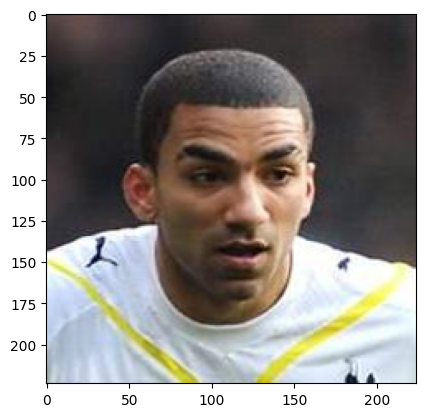

In [11]:
plt.imshow(X_train[0])
plt.show()

In [12]:
# Based on RESNET50 architecture -> new paper(2017)
vggface = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg', weights='vggface')
last_layer = vggface.layers[-2].output
x = layers.GlobalAveragePooling2D()(last_layer)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2) (x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2) (x)
x = layers.Dense(1, activation='sigmoid')(x)

inputs = vggface.inputs
outputs = x
model = Model(inputs, outputs)
for layer in model.layers[:-2]:
    layer.trainable = False

#categorical_crossentropy [0,1] [1,0]
#Testar binary_crossentropy [0-1]
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

# model.compile()
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

In [13]:
Y_train

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [14]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
model.fit(X_train, Y_train, epochs=15, validation_split=0.2, batch_size=128, shuffle = True)#, verbose=1, callbacks=[es])
print("Done Training")
#del features_train


Epoch 1/15
63/63 [==============================] - 27s 236ms/step - loss: 0.8741 - accuracy: 0.5437 - val_loss: 0.5245 - val_accuracy: 0.7545
Epoch 2/15
63/63 [==============================] - 13s 202ms/step - loss: 0.6067 - accuracy: 0.7006 - val_loss: 0.3915 - val_accuracy: 0.8655
Epoch 3/15
63/63 [==============================] - 13s 209ms/step - loss: 0.4895 - accuracy: 0.7710 - val_loss: 0.3302 - val_accuracy: 0.9045
Epoch 4/15
63/63 [==============================] - 13s 200ms/step - loss: 0.4400 - accuracy: 0.8015 - val_loss: 0.3067 - val_accuracy: 0.9140
Epoch 5/15
63/63 [==============================] - 13s 200ms/step - loss: 0.4084 - accuracy: 0.8240 - val_loss: 0.2756 - val_accuracy: 0.9195
Epoch 6/15
63/63 [==============================] - 13s 200ms/step - loss: 0.3833 - accuracy: 0.8391 - val_loss: 0.2728 - val_accuracy: 0.9230
Epoch 7/15
63/63 [==============================] - 13s 200ms/step - loss: 0.3726 - accuracy: 0.8454 - val_loss: 0.2557 - val_accuracy: 0.9255

In [15]:
Y_test_afro = np.array(y_test_afro)
model.evaluate(X_test_afro,Y_test_afro)
print("Done testing afro")

Y_test_asian = np.array(y_test_asian)
results_test_asian = model.evaluate(X_test_asian,Y_test_asian, return_dict=True)
print("Done testing asian")

Y_test_caucasian = np.array(y_test_caucasian)
results_test_caucasian = model.evaluate(X_test_caucasian,Y_test_caucasian, return_dict=True)
print("Done testing caucasian")

Y_test_indian = np.array(y_test_indian)
results_test_indian = model.evaluate(X_test_indian,Y_test_indian, return_dict=True)
print("Done testing indian")

79/79 [==============================] - 4s 49ms/step - loss: 0.4618 - accuracy: 0.8044
Done testing afro
79/79 [==============================] - 4s 47ms/step - loss: 0.3054 - accuracy: 0.8936
Done testing asian
79/79 [==============================] - 4s 45ms/step - loss: 0.3010 - accuracy: 0.8936
Done testing caucasian
79/79 [==============================] - 3s 44ms/step - loss: 0.2619 - accuracy: 0.9080
Done testing indian


In [16]:
last_conv_layer_name = "conv5_3_1x1_increase/bn"
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.99):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = utils.array_to_img(superimposed_img)

    # Save the superimposed image
    
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Img(cam_path))

In [17]:
def Separator(predicted_labels, y_test, FNidx, FPidx):
    for i in range(0,2500):
        if predicted_labels[i] < 0.5:
            if y_test[i] == [1]:
                    FNidx.append(i)
        if predicted_labels[i] >= 0.5:
            if y_test[i] == [0]:
                    FPidx.append(i)

predicted_labels_afro = model.predict(X_test_afro)
#cm_afro = confusion_matrix(y_test_afro, predicted_labels_afro)
#print("ConfusionMatrix afro\n",cm_afro)
AfroFPidx = []
AfroFNidx = []
Separator(predicted_labels_afro, y_test_afro, AfroFNidx, AfroFPidx)
#FPFNGenerator()

predicted_labels_asian = model.predict(X_test_asian)
#cm_asian = confusion_matrix(y_test_asian, predicted_labels_asian)
#print("ConfusionMatrix asian\n",cm_asian)
AsianFPidx = []
AsianFNidx = []
Separator(predicted_labels_asian, y_test_asian, AsianFNidx, AsianFPidx)

predicted_labels_caucasian = model.predict(X_test_caucasian)
#cm_caucasian = confusion_matrix(y_test_caucasian, predicted_labels_caucasian)
#print("ConfusionMatrix caucasian\n",cm_caucasian)
CaucasianFPidx = []
CaucasianFNidx = []
Separator(predicted_labels_caucasian, y_test_caucasian, CaucasianFNidx, CaucasianFPidx)

predicted_labels_indian = model.predict(X_test_indian)
#cm_indian = confusion_matrix(y_test_indian, predicted_labels_indian)
#print("ConfusionMatrix indian\n",cm_indian)IndianFPidx = []
IndianFPidx = []
IndianFNidx = []

Separator(predicted_labels_indian, y_test_indian, IndianFNidx, IndianFPidx)

print(AfroFPidx)
print(AfroFNidx)
print(AsianFPidx)
print(AsianFNidx)
print(CaucasianFPidx)
print(CaucasianFNidx)
print(IndianFPidx)
print(IndianFNidx)


79/79 [==============================] - 3s 41ms/step
[1250, 1252, 1255, 1260, 1261, 1262, 1266, 1268, 1270, 1272, 1276, 1278, 1282, 1286, 1288, 1292, 1300, 1302, 1305, 1313, 1316, 1318, 1320, 1322, 1332, 1340, 1342, 1344, 1346, 1350, 1352, 1362, 1366, 1367, 1370, 1375, 1376, 1378, 1380, 1382, 1386, 1388, 1390, 1392, 1395, 1396, 1402, 1408, 1410, 1412, 1416, 1422, 1430, 1432, 1435, 1438, 1442, 1446, 1448, 1450, 1452, 1453, 1458, 1460, 1462, 1466, 1468, 1470, 1472, 1478, 1480, 1482, 1486, 1490, 1492, 1495, 1502, 1510, 1512, 1515, 1516, 1522, 1530, 1532, 1536, 1538, 1540, 1542, 1544, 1545, 1552, 1557, 1560, 1562, 1565, 1568, 1572, 1578, 1580, 1582, 1586, 1588, 1590, 1592, 1602, 1605, 1606, 1610, 1612, 1615, 1616, 1620, 1622, 1625, 1627, 1628, 1630, 1632, 1642, 1645, 1652, 1655, 1662, 1665, 1672, 1678, 1682, 1690, 1691, 1692, 1695, 1698, 1700, 1701, 1702, 1710, 1717, 1720, 1722, 1726, 1732, 1740, 1742, 1745, 1752, 1755, 1762, 1765, 1772, 1778, 1780, 1782, 1784, 1788, 1790, 1791, 1792, 180

In [18]:
model.layers[-1].activation = None

heatmap = make_gradcam_heatmap(np.expand_dims(X_train[0], axis=0), model, last_conv_layer_name)
# plt.matshow(heatmap)
# plt.show()

save_and_display_gradcam(X_train[0], heatmap, cam_path = "cam.jpg")
save_and_display_gradcam(X_train[1], heatmap)
save_and_display_gradcam(X_train[2], heatmap)
save_and_display_gradcam(X_train[3], heatmap)
save_and_display_gradcam(X_train[4], heatmap)
save_and_display_gradcam(X_train[9999], heatmap)
# Display heatmap

C:\Users\mathe\AppData\Local\Temp\ipykernel_5572\1808066238.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [19]:
def FPFNGenerator(PathToFolder, idx, imgs, PathToCamFolder, y_pred, x_test):
    if not os.path.exists(PathToFolder):
        os.makedirs(PathToFolder)
    else:
        shutil.rmtree(PathToFolder)
        os.makedirs(PathToFolder)
    if not os.path.exists(PathToCamFolder):
            os.makedirs(PathToCamFolder)
    else:
        shutil.rmtree(PathToCamFolder)
        os.makedirs(PathToCamFolder)
    for i in idx:
        image = Image.fromarray(imgs[i])
        name = str('{:.3f}'.format(y_pred[i][0])) + "("+ str(x_test[1][i]) + ")" +".png"
        save_and_display_gradcam(imgs[i], heatmap, cam_path = PathToCamFolder + "/" + name)
        image_filename = os.path.join(PathToFolder, name)
        image.save(image_filename)

FPFNGenerator("./FACES/VMERBalanced/AfroFN",AfroFNidx, X_test_afro, "./FACES/VMERBalanced/AfroFNCam", predicted_labels_afro, x_test_afro)
FPFNGenerator("./FACES/VMERBalanced/AfroFP",AfroFPidx, X_test_afro, "./FACES/VMERBalanced/AfroFPCam", predicted_labels_afro, x_test_afro)

FPFNGenerator("./FACES/VMERBalanced/AsianFP",AsianFPidx, X_test_asian, "./FACES/VMERBalanced/AsianFPCam", predicted_labels_asian, x_test_asian)
FPFNGenerator("./FACES/VMERBalanced/AsianFN",AsianFNidx, X_test_asian, "./FACES/VMERBalanced/AsianFNCam", predicted_labels_asian, x_test_asian)

FPFNGenerator("./FACES/VMERBalanced/CaucasianFP",CaucasianFPidx, X_test_caucasian, "./FACES/VMERBalanced/CaucasianFPCam", predicted_labels_caucasian, x_test_caucasian)
FPFNGenerator("./FACES/VMERBalanced/CaucasianFN",CaucasianFNidx, X_test_caucasian, "./FACES/VMERBalanced/CaucasianFNCam", predicted_labels_caucasian, x_test_caucasian)

FPFNGenerator("./FACES/VMERBalanced/IndianFP",IndianFPidx, X_test_indian,"./FACES/VMERBalanced/IndianFPCam", predicted_labels_indian, x_test_indian)
FPFNGenerator("./FACES/VMERBalanced/IndianFN",IndianFNidx, X_test_indian, "./FACES/VMERBalanced/IndianFNCam", predicted_labels_indian, x_test_indian)


C:\Users\mathe\AppData\Local\Temp\ipykernel_5572\1808066238.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [20]:
predicted_labels_afro[2][0]

0.8015328

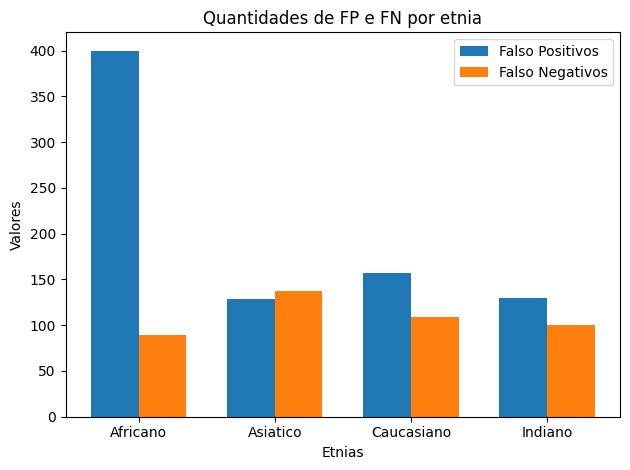

In [21]:
categorias = ['Africano', 'Asiatico', 'Caucasiano', 'Indiano']
FalsoPositivos = [len(AfroFPidx), len(AsianFPidx), len(CaucasianFPidx), len(IndianFPidx)]
FalsoNegativos = [len(AfroFNidx), len(AsianFNidx), len(CaucasianFNidx), len(IndianFNidx)]
x = range(len(categorias))
bar_width = 0.35

fig, ax = plt.subplots()


rects = ax.bar(x, FalsoPositivos, bar_width, label='Falso Positivos')
rects2 = ax.bar([pos + bar_width for pos in x], FalsoNegativos, bar_width, label='Falso Negativos')

ax.set_xlabel('Etnias')
ax.set_ylabel('Valores')
ax.set_title('Quantidades de FP e FN por etnia')
ax.set_xticks([pos + bar_width/2 for pos in x])
ax.set_xticklabels(categorias)
ax.legend()

plt.tight_layout()
# print("Afro\n",cm_afro)
# print("\nAsian\n",cm_asian)
# print("\nCaucasian\n",cm_caucasian)
# print("\nIndian\n",cm_indian)
plt.show()

In [22]:
ojashioadh
def extract_face(filename, required_size = (224, 224)):
 # load image from file
 pixels = plt.imread(filename)
 # create the detector, using default weights
 detector = mtcnn.MTCNN()
 # detect faces in the image
 results = detector.detect_faces(pixels)
 # extract the bounding box from the first face
 x1, y1, width, height = results[0]['box']
 x2, y2 = x1 + width, y1 + height
 # extract the face
 face = pixels[y1:y2, x1:x2]
 # resize pixels to the model size
 image = Image.fromarray(face)
 image = image.resize(required_size)
 face_array = np.asarray(image)
 return face_array

NameError: name 'ojashioadh' is not defined

9999


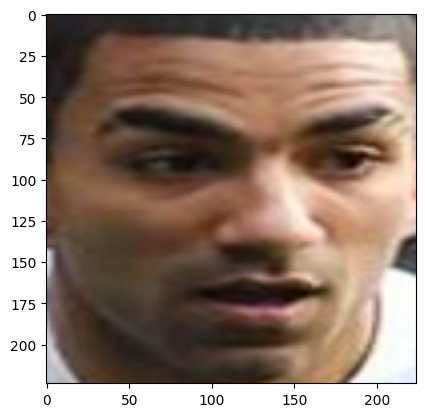

In [ ]:
detector = mtcnn.MTCNN()
face_array_train = np.zeros((10000,) + (224,224) + (3,), dtype=np.uint8)
for i in range(0, 10000):
    results = detector.detect_faces(X_train[i])
    clear_output(wait=True)
    print(i)
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = X_train[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_train[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_train[i] = X_train[i]
plt.imshow(face_array_train[0])
plt.show()

In [ ]:
face_array_test_afro = np.zeros((2500,) + (224,224) + (3,), dtype=np.uint8)
face_array_test_asian = np.zeros((2500,) + (224,224) + (3,), dtype=np.uint8)
face_array_test_caucasian = np.zeros((2500,) + (224,224) + (3,), dtype=np.uint8)
face_array_test_indian = np.zeros((2500,) + (224,224) + (3,), dtype=np.uint8)
for i in range(0, 2500):
    results = detector.detect_faces(X_test_afro[i])
    clear_output(wait=True)
    print(i)
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = X_test_afro[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_test_afro[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_test_afro[i] = X_test_afro[i]
plt.imshow(face_array_test_afro[0])
plt.show()

for i in range(0, 2500):
    results = detector.detect_faces(X_test_asian[i])
    clear_output(wait=True)
    print(i)
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = X_test_asian[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_test_asian[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_test_asian[i] = X_test_asian[i]
plt.imshow(face_array_test_asian[0])
plt.show()

for i in range(0, 2500):
    results = detector.detect_faces(X_test_caucasian[i])
    clear_output(wait=True)
    print(i)
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = X_test_caucasian[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_test_caucasian[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_test_caucasian[i] = X_test_caucasian[i]
plt.imshow(face_array_test_caucasian[0])
plt.show()

for i in range(0, 2500):
    results = detector.detect_faces(X_test_indian[i])
    clear_output(wait=True)
    print(i)
    if results:
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        face = X_test_indian[i][y1:y2, x1:x2]
        image = np.array(face)
        face_array_test_indian[i] = cv2.resize(image,(224, 224))
        del results, x1, y1, x2, y2, width, height, face, image
    else:
        face_array_test_indian[i] = X_test_indian[i]
plt.imshow(face_array_test_indian[0])
plt.show()

804
3/3 [==============================] - 0s 3ms/step


c:\Users\mathe\.conda\envs\IC\lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
c:\Users\mathe\.conda\envs\IC\lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
c:\Users\mathe\.conda\envs\IC\lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
c:\Users\mathe\.conda\envs\IC\lib\site-packages\mtcnn\mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


KeyboardInterrupt: 

In [ ]:
features_train = model.predict(face_array_train)
svm = SVC()
svm.fit(features_train, y_train)
print("Done Training")
#del features_train

features_test_afro_cropped = model.predict(face_array_test_afro)
print("Done Building features_test_afro_cropped")
accuracy_afro_cropped = svm.score(features_test_afro, y_test_afro)
print("Done testing")

features_test_asian_cropped = model.predict(face_array_test_asian)
print("Done Building features_test_asian_cropped")
accuracy_asian_cropped = svm.score(features_test_asian, y_test_asian)
print("Done testing")

features_test_caucasian_cropped = model.predict(face_array_test_caucasian)
print("Done Building features_test_caucasian_cropped")
accuracy_caucasian_cropped = svm.score(features_test_caucasian, y_test_caucasian)
print("Done testing")

features_test_indian_cropped = model.predict(face_array_test_indian)
print("Done Building features_test_indian_cropped")
accuracy_indian_cropped = svm.score(features_test_indian, y_test_indian)
print("Done testing")

In [ ]:
print("Cropped afro accuracy: ", accuracy_afro_cropped)
print("Non cropped afro accuracy: ", accuracy_afro)
print("\nCropped asian accuracy: ", accuracy_asian_cropped)
print("Non cropped asian accuracy: ", accuracy_asian)
print("\nCropped caucasian accuracy: ", accuracy_caucasian_cropped)
print("Non cropped caucasian accuracy: ", accuracy_caucasian)
print("\nCropped indian accuracy: ", accuracy_indian_cropped)
print("Non cropped indian accuracy: ", accuracy_indian)




In [ ]:
predicted_labels_afro_cropped = svm.predict(features_test_afro_cropped)
cm_afro_cropped = confusion_matrix(y_test_afro, predicted_labels_afro_cropped)

AfroFPidxCropped = []
AfroFNidxCropped = []
Separator(predicted_labels_afro_cropped, y_test_afro, AfroFNidxCropped, AfroFPidxCropped)

predicted_labels_asian_cropped = svm.predict(features_test_asian_cropped)
cm_asian_cropped = confusion_matrix(y_test_asian, predicted_labels_asian_cropped)

AsianFPidxCropped = []
AsianFNidxCropped = []
Separator(predicted_labels_asian_cropped, y_test_asian, AsianFNidxCropped, AsianFPidxCropped)

predicted_labels_caucasian_cropped = svm.predict(features_test_caucasian_cropped)
cm_caucasian_cropped = confusion_matrix(y_test_caucasian, predicted_labels_caucasian_cropped)

CaucasianFPidxCropped = []
CaucasianFNidxCropped = []
Separator(predicted_labels_caucasian_cropped, y_test_caucasian, CaucasianFNidxCropped, CaucasianFPidxCropped)

predicted_labels_indian_cropped = svm.predict(features_test_indian_cropped)
cm_indian_cropped = confusion_matrix(y_test_indian, predicted_labels_indian_cropped)

IndianFPidxCropped = []
IndianFNidxCropped = []
Separator(predicted_labels_indian_cropped, y_test_indian, IndianFNidxCropped, IndianFPidxCropped)

In [ ]:
def FPFNGenerator(PathToFolder, idx, imgs):
    if not os.path.exists(PathToFolder):
        os.makedirs(PathToFolder)
    else:
        shutil.rmtree(PathToFolder)
        os.makedirs(PathToFolder)
    for i in idx:
        image = Image.fromarray(imgs[i])
        image_filename = os.path.join(PathToFolder, f"{i}.png")
        image.save(image_filename)

FPFNGenerator("./FACES/VMERBalancedCropped/AfroFP",AfroFPidxCropped, face_array_test_afro)
FPFNGenerator("./FACES/VMERBalancedCropped/AfroFN",AfroFNidxCropped, face_array_test_afro)

FPFNGenerator("./FACES/VMERBalancedCropped/AsianFP",AsianFPidxCropped, face_array_test_asian)
FPFNGenerator("./FACES/VMERBalancedCropped/AsianFN",AsianFNidxCropped, face_array_test_asian)

FPFNGenerator("./FACES/VMERBalancedCropped/CaucasianFP",CaucasianFPidxCropped, face_array_test_caucasian)
FPFNGenerator("./FACES/VMERBalancedCropped/CaucasianFN",CaucasianFNidxCropped, face_array_test_caucasian)

FPFNGenerator("./FACES/VMERBalancedCropped/IndianFP",IndianFPidxCropped, face_array_test_indian)
FPFNGenerator("./FACES/VMERBalancedCropped/IndianFN",IndianFNidxCropped, face_array_test_indian)

In [ ]:
categorias = ['Africano', 'Asiatico', 'Caucasiano', 'Indiano']
FalsoPositivos = [len(AfroFPidxCropped), len(AsianFPidxCropped), len(CaucasianFPidxCropped), len(IndianFPidxCropped)]
FalsoNegativos = [len(AfroFNidxCropped), len(AsianFNidxCropped), len(CaucasianFNidxCropped), len(IndianFNidxCropped)]
x = range(len(categorias))
bar_width = 0.35

fig, ax = plt.subplots()


rects = ax.bar(x, FalsoPositivos, bar_width, label='Falso Positivos')
rects2 = ax.bar([pos + bar_width for pos in x], FalsoNegativos, bar_width, label='Falso Negativos')

ax.set_xlabel('Etnias')
ax.set_ylabel('Valores')
ax.set_title('Quantidades de FP e FN por etnia')
ax.set_xticks([pos + bar_width/2 for pos in x])
ax.set_xticklabels(categorias)
ax.legend()

plt.tight_layout()
print("Afro\n",cm_afro_cropped)
print("\nAsian\n",cm_asian_cropped)
print("\nCaucasian\n",cm_caucasian_cropped)
print("\nIndian\n",cm_indian_cropped)
plt.show()

In [ ]:
np.expand_dims(face_array_test_indian[0], axis=0).shape

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(model,
                          model_modifier=ReplaceToLinear(),
                          clone=True)

# Generate cam with GradCAM++
images = np.asarray([face_array_test_afro[0], face_array_test_asian[0], face_array_test_caucasian[0],face_array_test_indian[0]])
cam = gradcam(CategoricalScore([1,3,4,5]), images)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
image_titles = ["African", "Asian", "Caucasian", "Indian"]
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()